In [10]:
import numpy as np

from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams['axes.facecolor'] = 'lightgray'
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

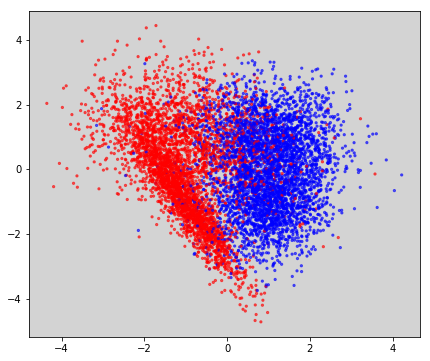

In [11]:
#Generate a dataset using sklearn.datasets and split it into parts
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000, random_state=56, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=2) 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

plt.figure(figsize=(7, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, s=5, alpha=0.6)
plt.show()

ROC-AUC score:
knn_5 = 0.880020034605
knn_10 = 0.890919980666
Linear SVM = 0.891568953767
RBF SVM = 0.900277802518
Random Forest_5 = 0.897816508235
Random Forest_10 = 0.896923857492
Neural Net = 0.895490812803


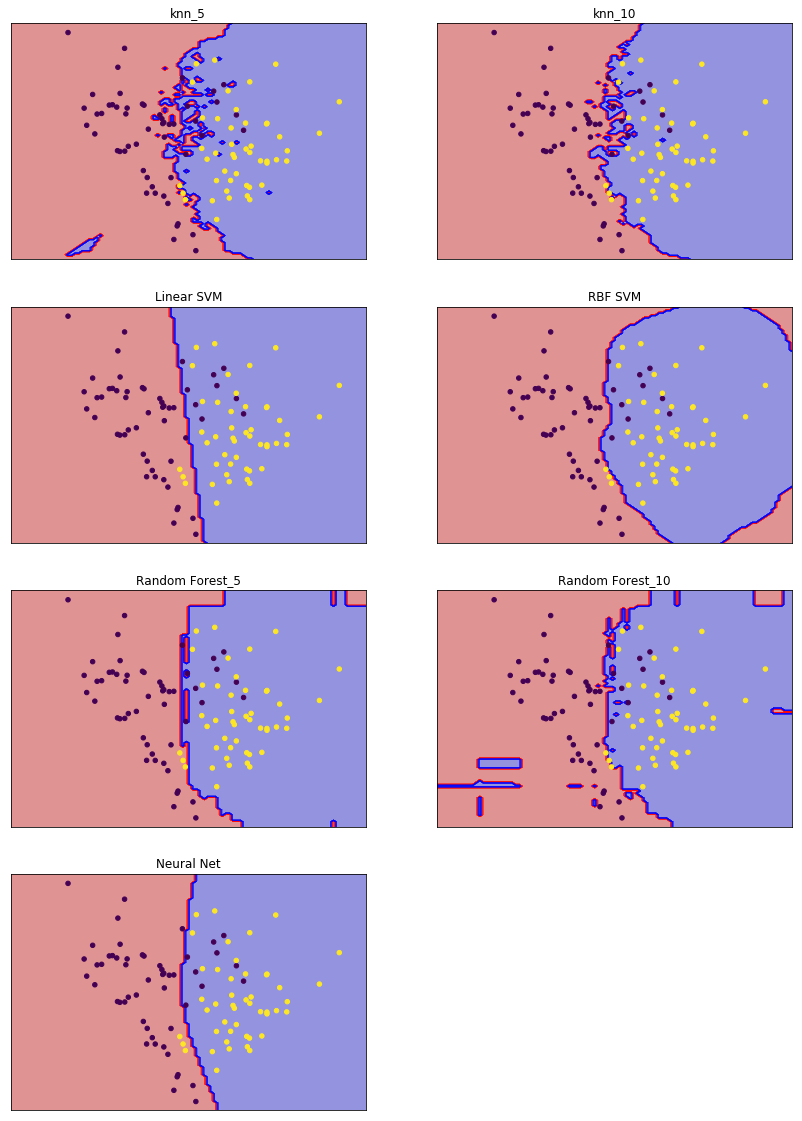

In [12]:
#Apply built-in scikit ML algorithms to the dataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

names = ["knn_5", "knn_10", "Linear SVM", "RBF SVM", 
         "Random Forest_5", "Random Forest_10", "Neural Net"]

classifiers = [
    KNeighborsClassifier(5),
    KNeighborsClassifier(10),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    RandomForestClassifier(max_depth=5, n_estimators=10),
    RandomForestClassifier(max_depth=10, n_estimators=10),
    MLPClassifier(alpha=1)]

print ('ROC-AUC score:')
i = 1
score = []
fig = plt.figure(figsize=(14,20))

for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        print (name + ' = ' + str(roc_auc_score(y_test, clf.predict(X_test))))
        score.append(roc_auc_score(y_test, clf.predict(X_test))) 
        xx, yy = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax = fig.add_subplot(4,2,i)
        ax.set_title(name)
        ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 20), cmap=cm_bright, alpha=0.3)
        ax.scatter(X[:100, 0], X[:100, 1], c=y[:100], s=20, alpha=1.0)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1    

In [13]:
#Define the 'Stacking' class with 'fit' and 'predict' analogous to built-in scikit-learn algorithms
from sklearn.base import BaseEstimator, ClassifierMixin

class Stacking(BaseEstimator, ClassifierMixin):  
    
    def __init__(self, classifiers, meta_algorithm):
        
        self.classifiers = classifiers
        self.meta_algorithm = meta_algorithm
        self.length = len(classifiers)
        self.test = None
        
    def fit(self, X, y):
        
        train, test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        self.test = np.zeros((test.shape[0], self.length))
        for n, clf in enumerate(self.classifiers):
            clf.fit(train, y_train)
            self.test[:, n] = clf.predict(test)

        self.meta_algorithm.fit(self.test, y_test)
        
        return self
    
    def predict(self, X):
        
        meta_feature = np.zeros((X.shape[0], self.length))
        
        for n, clf in enumerate(self.classifiers):
            meta_feature[:, n] = clf.predict(X)
        
        return self.meta_algorithm.predict(meta_feature)    

ROC-AUC score:
Stacking = 0.916788338699


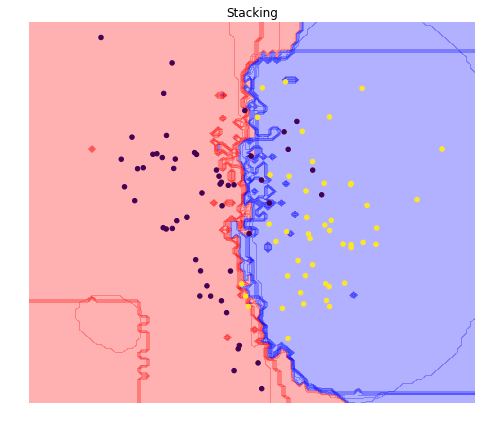

In [14]:
#Apply the built-in ML-algorithms within a common stack (the output of 
#       the ML-algorithms is a meta-feature space, where new learning takes place)
from sklearn.linear_model import LinearRegression

stacking = Stacking(classifiers, LinearRegression())
stacking.fit(X_train, y_train)
score_stacking = roc_auc_score(y_test, stacking.predict(X_test))
print ('ROC-AUC score:')
print ('Stacking' + ' = ' + str(score_stacking))

xx, yy = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
Z = stacking.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 7))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 20), cmap=cm_bright, alpha=0.3) 
plt.scatter(X[:100, 0], X[:100, 1], c=y[:100], s=20, alpha=1.0)
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.axis('off')
plt.title('Stacking')
plt.show()

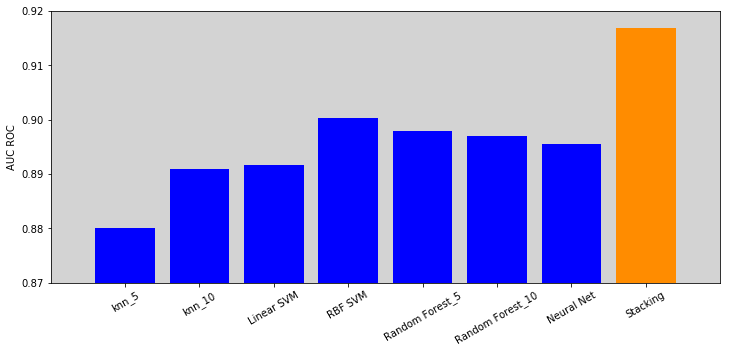

In [15]:
#Build histograms of AUC-ROC metric over the implemented approaches
xticks = [x for x in names]+['Stacking']
scores = [x for x in score]+[score_stacking]

plt.figure(figsize=(12, 5))
plt.bar(np.arange(len(scores)), scores, color='#0000FF')
plt.xticks(np.arange(len(scores)), xticks, rotation=30)
plt.bar(7, score_stacking, color='darkorange')

plt.xlim([-1, 8])
plt.ylim([0.87, 0.92])
plt.ylabel('AUC ROC')
plt.show()